In [1]:
# Cell 1: Import libraries dan setup environment
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random

print("Checking installed packages:")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")


Checking installed packages:
TensorFlow version: 2.15.0
NumPy version: 1.24.3
Pandas version: 1.5.3


CSV loaded successfully!

Data distribution after balancing:
Bags          200
Bottomwear    200
Dress         200
Headwear      200
Shoes         200
Topwear       200
Watches       200
Name: subCategory, dtype: int64


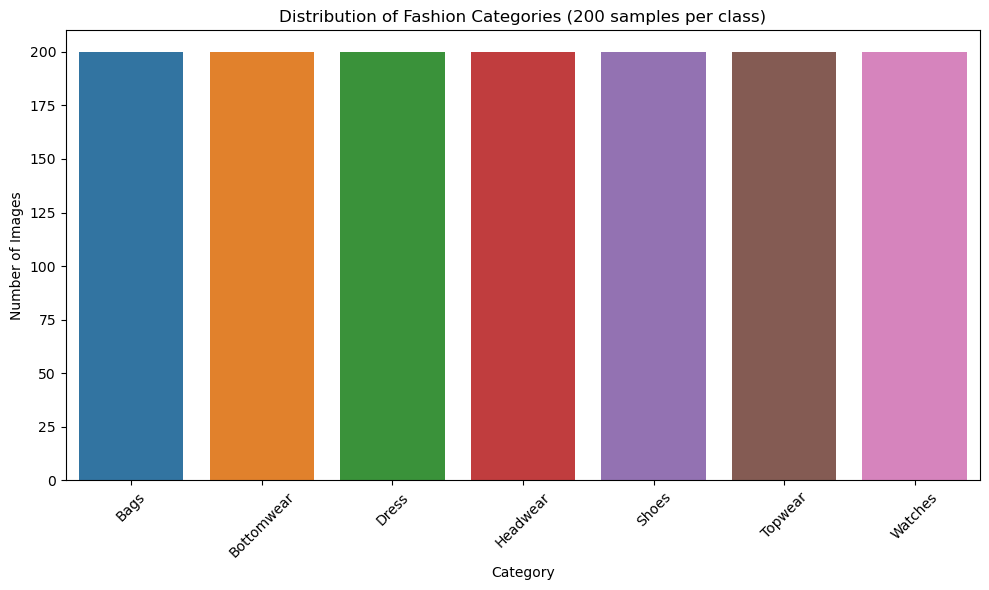

In [2]:
# Cell 2: Load dan analisis data dengan batasan
def analyze_dataset(csv_path='../Data/filtered_categories.csv', samples_per_class=200):
    try:
        df = pd.read_csv(csv_path)
        print("CSV loaded successfully!")
        
        # Ambil 200 samples per kategori
        balanced_df = pd.DataFrame()
        for category in df['subCategory'].unique():
            category_df = df[df['subCategory'] == category]
            # Jika jumlah data kurang dari 200, ambil semua. Jika lebih, ambil random 200
            sampled = category_df.sample(n=min(samples_per_class, len(category_df)), random_state=42)
            balanced_df = pd.concat([balanced_df, sampled])
        
        print("\nData distribution after balancing:")
        print(balanced_df['subCategory'].value_counts())
        
        # Visualize balanced distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(data=balanced_df, x='subCategory')
        plt.xticks(rotation=45)
        plt.title('Distribution of Fashion Categories (200 samples per class)')
        plt.xlabel('Category')
        plt.ylabel('Number of Images')
        plt.tight_layout()
        plt.show()
        
        return balanced_df
        
    except Exception as e:
        print(f"Error loading CSV: {str(e)}")
        return None

# Load balanced data
df = analyze_dataset()


In [3]:
# Cell 3: Data Loading Function dengan batasan
def load_limited_data(df, data_dir='../Dataset', samples_per_class=200):
    images = []
    labels = []
    class_names = ['Bags', 'Bottomwear', 'Dress', 'Headwear', 'Shoes', 'Topwear', 'Watches']
    class_map = {name: idx for idx, name in enumerate(class_names)}
    
    print("\nLoading images...")
    total_processed = 0
    
    for category in class_names:
        print(f"\nProcessing {category}")
        category_path = os.path.join(data_dir, category)
        if not os.path.exists(category_path):
            print(f"Directory not found: {category_path}")
            continue
        
        # Get list of all files in category
        all_files = os.listdir(category_path)
        # Randomly select 200 files or less if not enough files
        selected_files = random.sample(all_files, min(samples_per_class, len(all_files)))
        
        for file in selected_files:
            try:
                img_path = os.path.join(category_path, file)
                img = load_img(img_path, target_size=(177, 177))
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(class_map[category])
                
                total_processed += 1
                if total_processed % 50 == 0:  # Update progress more frequently for smaller dataset
                    print(f"Processed {total_processed} images")
                    
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
    
    print(f"\nTotal processed images: {total_processed}")
    return np.array(images), np.array(labels), class_names

# Load limited dataset
X, y, class_names = load_limited_data(df)


Loading images...

Processing Bags
Processed 50 images
Processed 100 images
Processed 150 images
Processed 200 images

Processing Bottomwear
Processed 250 images
Processed 300 images
Processed 350 images
Processed 400 images

Processing Dress
Processed 450 images
Processed 500 images
Processed 550 images
Processed 600 images

Processing Headwear
Processed 650 images
Processed 700 images
Processed 750 images
Processed 800 images

Processing Shoes
Processed 850 images
Processed 900 images
Processed 950 images
Processed 1000 images

Processing Topwear
Processed 1050 images
Processed 1100 images
Processed 1150 images
Processed 1200 images

Processing Watches
Processed 1250 images
Processed 1300 images
Processed 1350 images
Processed 1400 images

Total processed images: 1400


In [ ]:
# Cell 4: Data Splitting and Preprocessing
# Split data dengan proporsi yang sama
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print("\nData shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)


Data shapes:
X_train: (1120, 177, 177, 3)
X_test: (280, 177, 177, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam

def create_improved_model(input_shape=(177, 177, 3), num_classes=7):
    model = models.Sequential([
        # Data Augmentation Layer
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape,
                     kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), padding='same',
                     kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Third Convolutional Block
        layers.Conv2D(64, (3, 3), padding='same',
                     kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Dense Layers
        layers.Flatten(),
        layers.Dense(128, kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create model
model = create_improved_model()

# Build model dengan input shape yang eksplisit
model.build(input_shape=(None, 177, 177, 3))

# Compile dengan learning rate yang lebih kecil
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Setup callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        min_delta=0.001
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )
]

# Training configuration
train_config = {
    'batch_size': 16,
    'epochs': 50,
    'validation_split': 0.2,
    'callbacks': callbacks
}

# Now we can safely call summary()
print("Model Summary:")
model.summary()



Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 177, 177, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 177, 177, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 177, 177, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 177, 177, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 177, 177, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 177

In [ ]:
# Training
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=train_config['batch_size'],
    epochs=train_config['epochs'],
    callbacks=train_config['callbacks']
)

Epoch 1/50


70/70 [==============================] - 25s 317ms/step - loss: 5.3177 - accuracy: 0.4393 - val_loss: 5.7213 - val_accuracy: 0.1429 - lr: 1.0000e-04
Epoch 2/50
70/70 [==============================] - 26s 367ms/step - loss: 4.7625 - accuracy: 0.6018 - val_loss: 5.6091 - val_accuracy: 0.1964 - lr: 1.0000e-04
Epoch 3/50
70/70 [==============================] - 23s 325ms/step - loss: 4.4527 - accuracy: 0.6884 - val_loss: 5.4636 - val_accuracy: 0.2107 - lr: 1.0000e-04
Epoch 4/50
70/70 [==============================] - 26s 370ms/step - loss: 4.2996 - accuracy: 0.7188 - val_loss: 5.1697 - val_accuracy: 0.3500 - lr: 1.0000e-04
Epoch 5/50
70/70 [==============================] - 24s 338ms/step - loss: 4.1442 - accuracy: 0.7482 - val_loss: 4.7651 - val_accuracy: 0.4857 - lr: 1.0000e-04
Epoch 6/50
70/70 [==============================] - 23s 326ms/step - loss: 3.9797 - accuracy: 0.7848 - val_loss: 4.4927 - val_accuracy: 0.5143 - lr: 1.0000e-04
Epoch 7/50
70/70 [====================

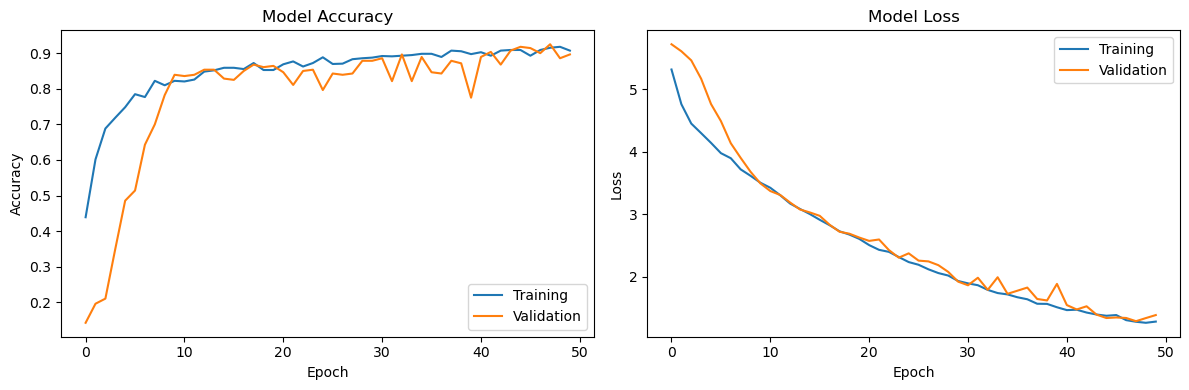

9/9 [==============================] - 1s 126ms/step

Classification Report:
              precision    recall  f1-score   support

        Bags       0.97      0.93      0.95        40
  Bottomwear       0.81      0.97      0.89        40
       Dress       0.90      0.88      0.89        40
    Headwear       0.97      0.85      0.91        40
       Shoes       0.75      1.00      0.86        40
     Topwear       0.97      0.75      0.85        40
     Watches       1.00      0.90      0.95        40

    accuracy                           0.90       280
   macro avg       0.91      0.90      0.90       280
weighted avg       0.91      0.90      0.90       280



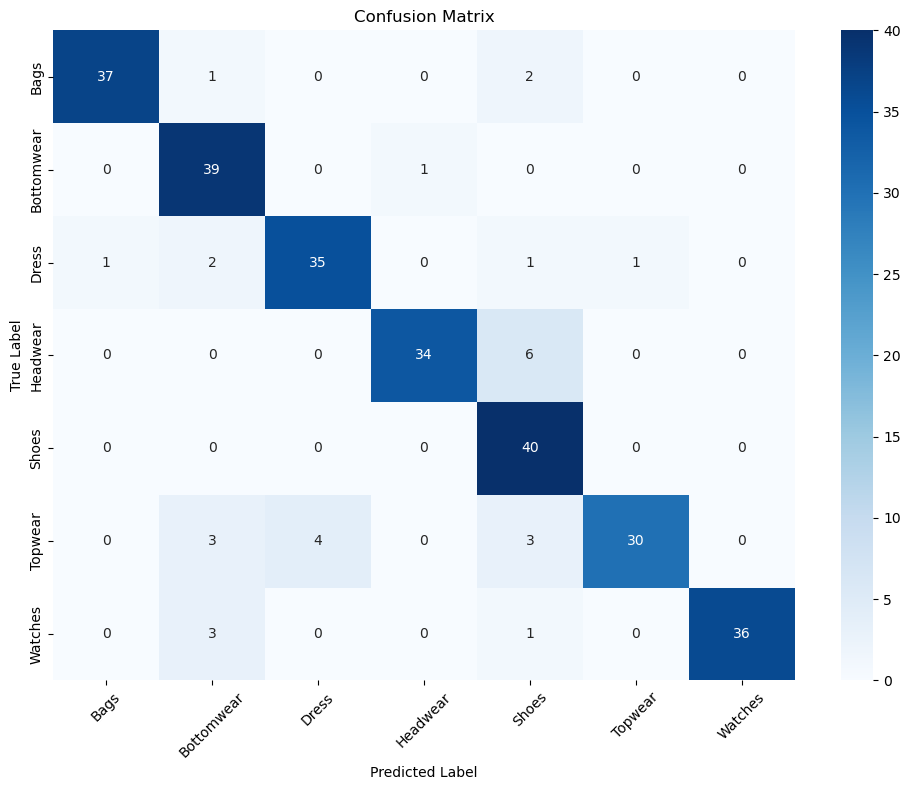

In [ ]:
# Cell 7: Evaluation and Visualization
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Cell 8: Save Model and Class Names
# Simpan model
model.save('fashion_classifier_model')

# Simpan class names ke JSON
import json
class_names_dict = class_names.tolist() if hasattr(class_names, 'tolist') else class_names
with open('class_names.json', 'w') as f:
    json.dump(class_names_dict, f)

print("Model and class names saved successfully!")


INFO:tensorflow:Assets written to: fashion_classifier_model\assets


INFO:tensorflow:Assets written to: fashion_classifier_model\assets


Model and class names saved successfully!
